In [ ]:
from datasets import load_dataset

In [2]:
sentiments = load_dataset('Sp1786/multiclass-sentiment-analysis-dataset')

In [3]:
sentiments

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label', 'sentiment'],
        num_rows: 31232
    })
    validation: Dataset({
        features: ['id', 'text', 'label', 'sentiment'],
        num_rows: 5205
    })
    test: Dataset({
        features: ['id', 'text', 'label', 'sentiment'],
        num_rows: 5206
    })
})

In [1]:
import os
from pathlib import Path

# Get the current working directory
cwd = os.getcwd()
print("Current Working Directory:", cwd)

Current Working Directory: C:\Users\NNAEMEKA\Documents\projects\sentiments\notebooks


In [2]:
os.chdir(Path(r'C:\Users\NNAEMEKA\Documents\projects\sentiments'))

In [3]:
path = 'data/datasets'
if not os.path.exists(path):
    os.makedirs(path)

In [ ]:
sentiments['train'].to_csv(f'{path}/train.csv', index=False)
sentiments['test'].to_csv(f'{path}/test.csv', index=False)
sentiments['validation'].to_csv(f'{path}/validation.csv', index=False)

In [4]:
import pandas as pd
import numpy as np

In [5]:
train_df = pd.read_csv(f'{path}/train.csv')
val_df = pd.read_csv(f'{path}/validation.csv')

In [6]:
train_df.head()

,id,text,label,sentiment
0,9536,"Cooking microwave pizzas, yummy",2,positive
1,6135,Any plans of allowing sub tasks to show up in ...,1,neutral
2,17697,"I love the humor, I just reworded it. Like sa...",2,positive
3,14182,naw idk what ur talkin about,1,neutral
4,17840,That sucks to hear. I hate days like that,0,negative


In [7]:
print(len(train_df))
train_df.describe()

31232


,id,label
count,31232.000000,31232.000000
mean,10576.775359,1.043961
std,8010.753795,0.790636
min,0.000000,0.000000
25%,3476.000000,0.000000
50%,8662.000000,1.000000
75%,17071.500000,2.000000
max,27480.000000,2.000000


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31232 entries, 0 to 31231
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         31232 non-null  int64 
 1   text       31232 non-null  object
 2   label      31232 non-null  int64 
 3   sentiment  31232 non-null  object
dtypes: int64(2), object(2)
memory usage: 976.1+ KB


In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
train_sentiment = train_df['sentiment'].value_counts().keys()
train_counts = train_df['sentiment'].value_counts().values

In [11]:
val_sentiment = val_df['sentiment'].value_counts().keys()
val_counts = val_df['sentiment'].value_counts().values

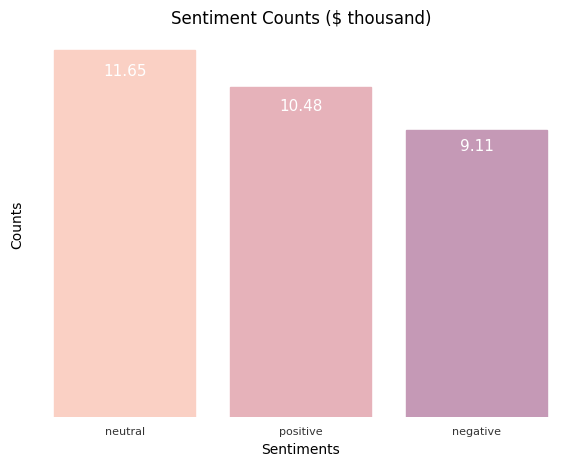

In [12]:
# Training data plot
plt.figure(figsize=(7, 5))
bars = plt.bar(x= train_sentiment, height=train_counts)
for bar, color in zip(bars, ['#FAD0C4', '#E6B2BA', '#C599B6']):
    bar.set_color(color)
    
plt.title('Sentiment Counts ($ thousand)') 
plt.xlabel('Sentiments')
plt.ylabel('Counts')
plt.xticks(fontsize=8, alpha=0.8)
plt.tick_params(bottom=False, left=False, right=False, labelleft=False)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

thousand = 1000
for bar in bars:
    plt.gca().text(bar.get_x() + bar.get_width()/2, bar.get_height()- (bar.get_height()* 0.07), '{:.2f}'.format(bar.get_height()/thousand), 
                        ha='center', color='w', fontsize=11)
plt.show()

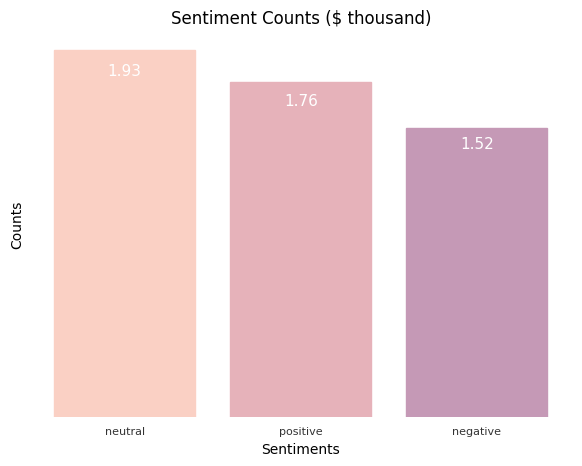

In [13]:
# validation data plot
plt.figure(figsize=(7, 5))
bars = plt.bar(x= val_sentiment, height=val_counts)
for bar, color in zip(bars, ['#FAD0C4', '#E6B2BA', '#C599B6']):
    bar.set_color(color)
    
plt.title('Sentiment Counts ($ thousand)') 
plt.xlabel('Sentiments')
plt.ylabel('Counts')
plt.xticks(fontsize=8, alpha=0.8)
plt.tick_params(bottom=False, left=False, right=False, labelleft=False)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

thousand = 1000
for bar in bars:
    plt.gca().text(bar.get_x() + bar.get_width()/2, bar.get_height()- (bar.get_height()* 0.07), '{:.2f}'.format(bar.get_height()/thousand), 
                        ha='center', color='w', fontsize=11)
plt.show()

In [14]:
# Not much class imbalance 
from wordcloud import WordCloud

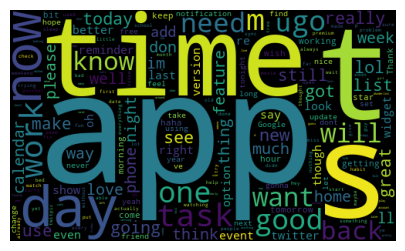

In [15]:
# Most frequent tokens for each tag
label = "neutral"
plt.figure(figsize=(10, 3))
subset = train_df[train_df.sentiment == label]
text = subset.text.values
cloud = WordCloud(background_color="black", collocations=False,
    width=500, height=300).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)

In [16]:
# No duplications
train_df[train_df.duplicated(["text"], keep= False)] # data leaks

,id,text,label,sentiment


In [17]:
# No duplications
val_df[val_df.duplicated(["text"], keep= False)] # data leaks

,id,text,label,sentiment


In [18]:
class_to_index = {'negative': 0, 'neutral': 1, 'positive': 2}
index_to_class = {v:k for k, v in class_to_index.items()}
print(class_to_index)
print(index_to_class)

{'negative': 0, 'neutral': 1, 'positive': 2}
{0: 'negative', 1: 'neutral', 2: 'positive'}


In [19]:
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PolynomialDecay

In [20]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
stopwords = stopwords.words('english')

In [25]:
import re

def clean_text(text):

    text= text.lower()

    # Remove stopwords
    pattern = re.compile(r"\b(" + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub("", text)
    text = SnowballStemmer('english').stem(text)
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # Remove non alphanumeric chars
    text = text.strip()  # Strip white space at the ends
    return text

In [24]:
train_df['text'] = train_df['text'].apply(clean_text)
val_df['text'] = val_df['text'].apply(clean_text)

In [21]:
val_df['text']

0       Laying in bed til workkk... Oh the life. Defin...
1        ooohhh imma need you to get on that asap love...
2        Thanks! I love it they have a video, so you d...
3          I left my ipod in the car so now its all warm.
4       Great app. Only complaint is that I'd like the...
                              ...                        
5200    Not sure what happened but now I have to hit t...
5201    Pretty good app, lets you organize tasks by ca...
5202    This app is a piece of sh**. It won't sync my ...
5203    : Very interested. However, low carbs for the ...
5204    Good app, but not exactly what I was looking f...
Name: text, Length: 5205, dtype: object

In [22]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 5000
max_length = 128
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Generate the word index dictionary
tokenizer.fit_on_texts(train_df['text'])
word_index = tokenizer.word_index

# Generate and pad the training sequences
training_sequences = tokenizer.texts_to_sequences(train_df['text'])
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Generate and pad the testing sequences
testing_sequences = tokenizer.texts_to_sequences(val_df['text'])
val_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Convert the labels lists into numpy arrays
training_labels = np.array(train_df['sentiment'].map(class_to_index))
val_labels = np.array(val_df['sentiment'].map(class_to_index))

In [23]:
len(word_index)

29766

In [24]:
training_padded

array([[2677,    1,    1, ...,    0,    0,    0],
       [ 124, 1063,   12, ...,    0,    0,    0],
       [   2,   44,    4, ...,    0,    0,    0],
       ...,
       [ 632,    0,    0, ...,    0,    0,    0],
       [   9,  759, 1760, ...,    0,    0,    0],
       [ 382,    4,  355, ...,    0,    0,    0]], dtype=int32)

In [25]:
training_labels

array([2, 1, 2, ..., 2, 1, 0])

In [26]:
val_padded

array([[2572,   14,  257, ...,    0,    0,    0],
       [   1, 2376,   85, ...,    0,    0,    0],
       [ 109,    2,   44, ...,    0,    0,    0],
       ...,
       [  17,   13,    9, ...,    0,    0,    0],
       [  63, 1511,  325, ...,    0,    0,    0],
       [  33,   13,   15, ...,    0,    0,    0]], dtype=int32)

In [27]:
val_labels

array([0, 2, 2, ..., 0, 2, 2])

In [28]:
len(training_padded)

31232

In [ ]:
# Parameters
embedding_dim = 32
lstm_dim = 64
dense_dim = 32


params = {
    "learning_rate": 5e-5,
    "vocab_size": 5000,
    "num_epochs": 5,
}
train_size = len(training_padded)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
num_train_steps = train_size * params["num_epochs"]
                                
lr_scheduler = PolynomialDecay(
    initial_learning_rate=params["learning_rate"],
    end_learning_rate=0.0,
    decay_steps=num_train_steps,
)

optimizer = Adam(learning_rate=lr_scheduler)
metrics = [SparseCategoricalAccuracy("accuracy")]

In [28]:
# Parameters
embedding_dim = 32 # from
lstm_dim = 64
dense_dim = 32

params = {
    "learning_rate": 5e-5,
    "vocab_size": 5000,
    "num_epochs": 5,
}
# Model Definition with LSTM
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Set the training parameters
model_lstm.compile(loss='sparse_categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
model_lstm.build(input_shape=(64, 32))
# Print the model summary
model_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (64, 32, 64)                │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (64, 128)                   │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (64, 32)                    │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (64, 3)                     │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 390,275 (1.49 MB)

 Trainable params: 390,275 (1.49 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Train the model
history_lstm = model_lstm.fit(training_padded, training_labels, epochs=params["num_epochs"], validation_data=(val_padded, val_labels))

Epoch 1/5
976/976 ━━━━━━━━━━━━━━━━━━━━ 122s 116ms/step - accuracy: 0.5366 - loss: 0.9213 - val_accuracy: 0.6866 - val_loss: 0.7196
Epoch 2/5
976/976 ━━━━━━━━━━━━━━━━━━━━ 125s 128ms/step - accuracy: 0.7334 - loss: 0.6458 - val_accuracy: 0.6951 - val_loss: 0.6981
Epoch 3/5
976/976 ━━━━━━━━━━━━━━━━━━━━ 114s 117ms/step - accuracy: 0.7669 - loss: 0.5753 - val_accuracy: 0.7036 - val_loss: 0.6943
Epoch 4/5
976/976 ━━━━━━━━━━━━━━━━━━━━ 123s 126ms/step - accuracy: 0.7902 - loss: 0.5199 - val_accuracy: 0.6903 - val_loss: 0.7181
Epoch 5/5
976/976 ━━━━━━━━━━━━━━━━━━━━ 122s 124ms/step - accuracy: 0.8145 - loss: 0.4714 - val_accuracy: 0.6947 - val_loss: 0.7959


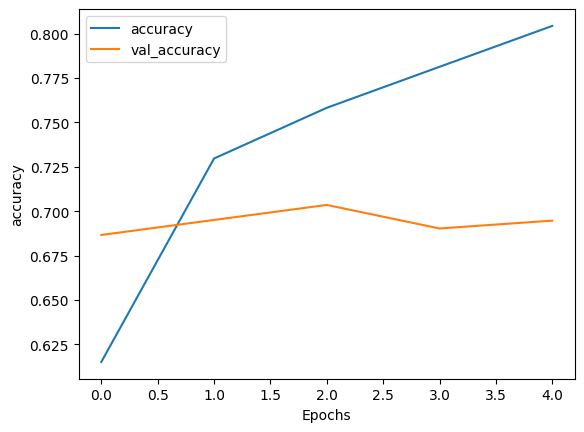

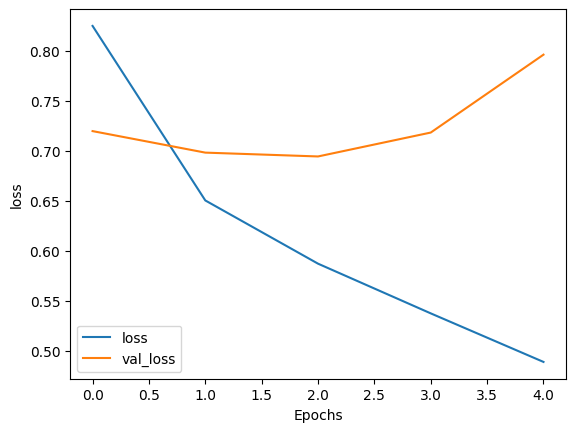

In [30]:
import matplotlib.pyplot as plt

# Plot Utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and loss history
plot_graphs(history_lstm, 'accuracy')
plot_graphs(history_lstm, 'loss')

In [31]:
model_lstm.save('datasets/sentiment.keras')

FileNotFoundError: [Errno 2] No such file or directory: 'datasets/sentiment.keras'

In [ ]:
model_lstm = tf.keras.models.load_model('datasets/sentiment.keras')

In [29]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    precision_recall_fscore_support,
)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [30]:
test_df = pd.read_csv(f'{path}/test.csv')

test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5206 entries, 0 to 5205
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         5206 non-null   int64 
 1   text       5205 non-null   object
 2   label      5206 non-null   int64 
 3   sentiment  5206 non-null   object
dtypes: int64(2), object(2)
memory usage: 162.8+ KB


In [31]:
test_df.dropna(inplace= True, axis=0, ignore_index=True)

In [32]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5205 entries, 0 to 5204
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         5205 non-null   int64 
 1   text       5205 non-null   object
 2   label      5205 non-null   int64 
 3   sentiment  5205 non-null   object
dtypes: int64(2), object(2)
memory usage: 162.8+ KB


In [35]:
test_df['sentiment'].value_counts()

sentiment
neutral     1929
positive    1730
negative    1546
Name: count, dtype: int64

In [50]:
test_df['text'] = test_df['text'].apply(clean_text)

In [41]:

test_token = tokenizer.texts_to_sequences(test_df['text'])
test_padded = pad_sequences(test_token, maxlen=max_length, padding=padding_type, truncating=trunc_type)
y_true = np.array(test_df['sentiment'].map(class_to_index))

In [144]:
model_lstm.evaluate(test_padded, y_true)

163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.6975 - loss: 0.8030


[0.8055410981178284, 0.6958693265914917]

In [39]:
y_pred = model_lstm.predict(test_padded)

163/163 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step


In [40]:
y_pred = np.argmax(y_pred, axis=-1)
len(y_pred)

5205

In [100]:
test_padded[0].shape
test_df.iloc[0]

id                                 9235
text         getting cds ready for tour
label                                 1
sentiment                       neutral
predicted                       neutral
Name: 0, dtype: object

In [101]:
ty_pred = model_lstm.predict(np.array(test_padded[0].reshape(1, 128)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


In [108]:
ty_pred.tolist()

[[0.0045743598602712154, 0.9909532070159912, 0.00447242334485054]]

In [127]:
test_df.head()

,id,text,label,sentiment,predicted
0,9235,getting cds ready for tour,1,neutral,neutral
1,16790,"MC, happy mother`s day to your mom ;).. love yah",2,positive,positive
2,24840,A year from now is graduation....i am pretty s...,0,negative,neutral
3,20744,because you had chips and sale w/o me,1,neutral,negative
4,6414,Great for organising my work life balance,2,positive,positive


In [112]:
def format_probability(probabilities, index_to_class):
    all_prob = {}
    for i, item in enumerate(probabilities):
        all_prob[index_to_class[i]] = item
    return all_prob

In [162]:
test_df.head(1)
ayt_token = tokenizer.texts_to_sequences(test_df.head(1)['text'])
ayt = pad_sequences(ayt_token, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [163]:
ty5_pred = model_lstm.predict(ayt)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


In [157]:
ty5_pred

array([[0.00457436, 0.9909532 , 0.00447242]], dtype=float32)

In [142]:
results = []  # Empty list to store result
for pred in ty5_pred:#.tolist():
    
    indices = np.argmax(pred, axis=-1)
    category = [index_to_class[index] for index in [indices]][0]
    results.append(
        {
            "prediction": category,
            "probabilities": format_probability(
                pred, index_to_class
            ),
        }
    )
    

In [143]:
results

[{'prediction': 'neutral',
  'probabilities': {'negative': np.float32(0.0045743575),
   'neutral': np.float32(0.9909532),
   'positive': np.float32(0.004472421)}},
 {'prediction': 'positive',
  'probabilities': {'negative': np.float32(8.370155e-05),
   'neutral': np.float32(0.0013924896),
   'positive': np.float32(0.9985239)}},
 {'prediction': 'neutral',
  'probabilities': {'negative': np.float32(0.10954763),
   'neutral': np.float32(0.64815265),
   'positive': np.float32(0.24229977)}},
 {'prediction': 'negative',
  'probabilities': {'negative': np.float32(0.6090402),
   'neutral': np.float32(0.28636158),
   'positive': np.float32(0.104598165)}},
 {'prediction': 'positive',
  'probabilities': {'negative': np.float32(0.001501563),
   'neutral': np.float32(0.01907696),
   'positive': np.float32(0.9794214)}},
 {'prediction': 'neutral',
  'probabilities': {'negative': np.float32(0.0813907),
   'neutral': np.float32(0.74700636),
   'positive': np.float32(0.17160296)}},
 {'prediction': 'neut

In [41]:
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred=y_pred, average="weighted")

In [42]:
{"precision": precision, "recall": recall, "f1": f1}

{'precision': 0.6975293726045142,
 'recall': 0.6958693563880883,
 'f1': 0.6950714233305352}

In [43]:
accuracy = accuracy_score(y_true, y_pred)

In [44]:
accuracy

0.6958693563880883

In [45]:
indices = class_to_index.values()
index_to_class = {v: k for k, v in class_to_index.items()}
labels = [index_to_class[index] for index in indices]

In [46]:
class_report = classification_report(
        y_true, y_pred, target_names=labels, output_dict=True
    )

In [47]:
class_report

{'negative': {'precision': 0.7290566037735849,
  'recall': 0.6248382923673997,
  'f1-score': 0.6729362591431557,
  'support': 1546.0},
 'neutral': {'precision': 0.6270270270270271,
  'recall': 0.6614826334888543,
  'f1-score': 0.6437941473259334,
  'support': 1929.0},
 'positive': {'precision': 0.7479674796747967,
  'recall': 0.7976878612716763,
  'f1-score': 0.772027972027972,
  'support': 1730.0},
 'accuracy': 0.6958693563880883,
 'macro avg': {'precision': 0.7013503701584697,
  'recall': 0.6946695957093101,
  'f1-score': 0.6962527928323538,
  'support': 5205.0},
 'weighted avg': {'precision': 0.6975293726045142,
  'recall': 0.6958693563880883,
  'f1-score': 0.6950714233305352,
  'support': 5205.0}}

In [48]:
test_df['sentiment'].value_counts()

sentiment
neutral     1929
positive    1730
negative    1546
Name: count, dtype: int64

In [45]:
classes = list(test_df['sentiment'].value_counts().keys())

In [50]:
classes

['neutral', 'positive', 'negative']

In [146]:
ty5_p = np.argmax(ty5_pred, axis=-1)

In [147]:
confusion_class = {}
for cat in classes:
  index = class_to_index[cat]
  tp, fp, fn = [], [], []
  for i, true in enumerate(y_true):
    pred = ty5_p[i]
    if index==true==pred:
        tp.append(i)
    elif index!=true and index==pred:
        fp.append(i)
    elif index==true and index!=pred:
        fn.append(i)
  confusion_class[cat] = {"tp": (tp, len(tp)), "fp": (fp, len(fp)), "fn": (fn, len(fn))}

In [153]:
confusion_class['positive']["tp"][1]

1380

In [53]:
test_df['predicted'] = pd.Series(y_pred).map(index_to_class)

In [54]:
test_df

,id,text,label,sentiment,predicted
0,9235,getting cds ready for tour,1,neutral,neutral
1,16790,"MC, happy mother`s day to your mom ;).. love yah",2,positive,positive
2,24840,A year from now is graduation....i am pretty s...,0,negative,neutral
3,20744,because you had chips and sale w/o me,1,neutral,negative
4,6414,Great for organising my work life balance,2,positive,positive
...,...,...,...,...,...
5200,10277,Fuck no internet damn time warner!,0,negative,negative
5201,8610,Looking forward to android 1.5 being pushed t...,1,neutral,positive
5202,8114,Not good. Wasted time.,0,negative,negative
5203,3034,"U were great, as always. But, can`t we do an ...",2,positive,neutral


In [55]:
neutral = confusion_class["neutral"]["fp"][0]# confusion_class["neutral"]["fn"][0] #+  + confusion_class["neutral"]["tp"][0]# 
test_df.iloc[neutral]#["text"][2]#.head()

,id,text,label,sentiment,predicted
2,24840,A year from now is graduation....i am pretty s...,0,negative,neutral
7,20403,remember the guy who 1st #tweetbud you! ~> _2...,2,positive,neutral
8,1896,She! Maybe that was our first mistake. Not e...,0,negative,neutral
11,8975,I saw an all red Audi on the highway. I sped ...,0,negative,neutral
12,9976,I loved this app. Worked so great I purchased ...,2,positive,neutral
...,...,...,...,...,...
5188,779,I used this app many years ago but I can't rem...,2,positive,neutral
5193,20603,kate is leaving me all by my lonesome,0,negative,neutral
5195,13101,my riding time has been dismal too during the...,0,negative,neutral
5203,3034,"U were great, as always. But, can`t we do an ...",2,positive,neutral


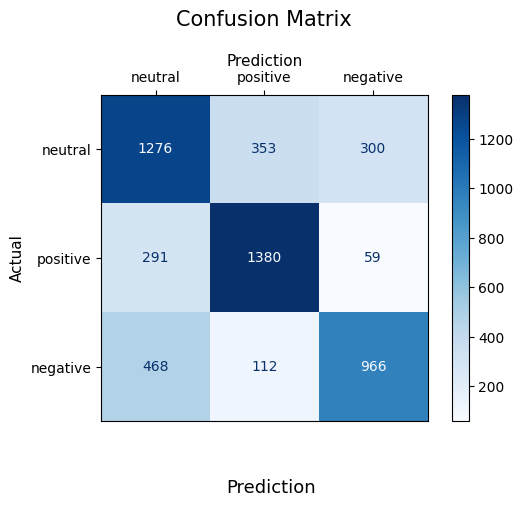

In [56]:
# Convert integer indices to string labels
y_true_str = [index_to_class[x] for x in y_true]
y_pred_str = [index_to_class[x] for x in y_pred]
labels =  list(dict.fromkeys(y_true_str))

# Generate the confusion matrix
cm = confusion_matrix(y_true_str, y_pred_str, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

#Customizations
plt.gca().xaxis.set_label_position('top')
plt.gca().xaxis.tick_top()
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)

plt.show()

In [57]:
history_lstm.history["val_loss"]

[0.719582736492157,
 0.6980836987495422,
 0.6942550539970398,
 0.7181382179260254,
 0.7959443926811218]

In [58]:
metrics = {
    "accuracy": accuracy,
    "precision": precision,
    "f1_score": f1,
    "recall": recall,
    "val_loss": history_lstm.history["val_loss"][-1],
    "val_accuracy": history_lstm.history["val_accuracy"][-1] 
    }

In [59]:
#mlflow server --backend-store-uri file:///tmp/%GITHUB_USERNAME%/mlflow --default-artifact-root file:///tmp//%GITHUB_USERNAME%/mlflow --host 127.0.0.1 --port 5000

In [3]:
import os
from pathlib import Path
import mlflow
from mlflow.models import infer_signature

In [4]:
MLFLOW_DIR = Path(
    f"/tmp/{os.environ.get('GITHUB_USERNAME', 'codebasetwo')}/mlflow"
).absolute()
Path(MLFLOW_DIR).mkdir(parents=True, exist_ok=True)
MLFLOW_TRACKING_URI = "file:///" + str(MLFLOW_DIR)
print(MLFLOW_TRACKING_URI)

file:///C:\tmp\codebasetwo\mlflow


In [5]:
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

In [63]:
params = {
    "learning_rate": 5e-5,
    "vocab_size": 5000,
    "num_epochs": 5,
}

In [90]:
import logging

logging.getLogger("mlflow").setLevel(logging.DEBUG)

In [33]:
experiment_name = "Sentiment-Classifier"

In [65]:
# Create MLflow Experiment
mlflow.set_experiment(experiment_name)
# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the loss metric
    mlflow.log_metrics(metrics)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "without cleaning text")

    # Infer the model signature
    signature = infer_signature(training_padded, model_lstm.predict(training_padded))

    # Log the model
    model_info = mlflow.tensorflow.log_model(
        model_lstm,
        artifact_path="sentiment_classifier",
        signature=signature,
        input_example=training_padded,
    )

2025/03/02 10:52:58 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



976/976 ━━━━━━━━━━━━━━━━━━━━ 38s 39ms/step


C:\Users\NNAEMEKA\miniconda3\envs\sentiment\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


976/976 ━━━━━━━━━━━━━━━━━━━━ 37s 37ms/step


In [34]:
metric =  "val_loss"
mode =  "ASC"

runs = mlflow.search_runs(
            experiment_names=[experiment_name],
            order_by=[f"metrics.{metric} {mode}"],
        )

In [35]:
best_run = runs.iloc[0]
best_run_id = best_run.run_id
best_loss = best_run[f"metrics.{metric}"]
print(best_run_id)
print(f"Best val loss: {best_loss}")

011a26e6a5924751b3c0b7325592b027
Best val loss: 0.6872177124023438


In [36]:
model = mlflow.tensorflow.load_model(f"runs:/{best_run_id}/sentiment_classifier")

In [42]:
etxx_pred = model.predict(test_padded)

163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step


In [43]:
etxx_index = np.argmax(etxx_pred, axis=-1)

In [46]:
confusion_class = {}
for cat in classes:
  index = class_to_index[cat]
  tp, fp, fn = [], [], []
  for i, true in enumerate(y_true):
    pred = etxx_index[i]
    if index==true==pred:
        tp.append(i)
    elif index!=true and index==pred:
        fp.append(i)
    elif index==true and index!=pred:
        fn.append(i)
  confusion_class[cat] = {"tp": (tp, len(tp)), "fp": (fp, len(fp)), "fn": (fn, len(fn))}

In [48]:
test_df['predicted'] = pd.Series(etxx_index).map(index_to_class)

In [52]:
neutral = confusion_class["positive"]["tp"][0]# confusion_class["neutral"]["fn"][0] #+  + confusion_class["neutral"]["tp"][0]# 
test_df.iloc[neutral]#["text"][2]#.head()

,id,text,label,sentiment,predicted
1,16790,"MC, happy mother`s day to your mom ;).. love yah",2,positive,positive
4,6414,Great for organising my work life balance,2,positive,positive
10,3086,but but it was funny when I wrote it,2,positive,positive
12,9976,I loved this app. Worked so great I purchased ...,2,positive,positive
20,258,"Lots of tasks to complete today. First, weclom...",2,positive,positive
...,...,...,...,...,...
5174,13544,_Ho Naw; it was before the 15 mins bug (where ...,2,positive,positive
5175,18967,happy mothers day to all the baby mommasss! rofl,2,positive,positive
5179,19776,"Susan Egan, I love her! And yeah, it said I w...",2,positive,positive
5181,15878,Oh wow Thanks for the info.,2,positive,positive


In [68]:
model_info

In [73]:
model_info.artifact_path

'sentiment_classifier'

In [1]:
import json

In [2]:
json.loads('{"id":9536,"text":"Cooking microwave pizzas, yummy","label":2,"sentiment":"positive"}')

{'id': 9536,
 'text': 'Cooking microwave pizzas, yummy',
 'label': 2,
 'sentiment': 'positive'}